In [1]:
!pip install pmdarima
!pip install quandl

     |████████████████████████████████| 1.5MB 2.9MB/s 
     |████████████████████████████████| 8.7MB 16.9MB/s 
     |████████████████████████████████| 2.1MB 46.0MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
  Found existing installation: Cython 0.29.21
    Uninstalling Cython-0.29.21:
      Successfully uninstalled Cython-0.29.21


In [2]:
# Importing all the required libraries
import requests
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn

from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.stattools import adfuller,kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA

from pmdarima.arima import auto_arima
import statsmodels.graphics.tsaplots as tsaplot

import quandl

from statsmodels.tsa.holtwinters import Holt, ExponentialSmoothing, SimpleExpSmoothing

Creating API request for getting data on NYSE


In [3]:
# Creating an API request to get the data for a stock.
req = requests.get('https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=IBM&outputsize=full&apikey=O4WUK21EQAE63NZJ&datatype=csv')

In [4]:
# Transforming the content of the request to a dataframe.
request_content = req.content
data = list(map(lambda x: x.split(','),request_content.decode('utf-8').split("\r\n")))
dataframe = pd.DataFrame(data[1:], columns=data[0])
dataframe = dataframe.set_index('timestamp')
dataframe.index = pd.to_datetime(dataframe.index)
dataframe.head()

,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient
timestamp,,,,,,,,
2020-07-20,126.0700,127.0700,125.1400,126.3700,126.3700,6395700,0.0000,1.0000
2020-07-17,124.3900,125.6300,123.2000,125.1100,125.1100,3984000,0.0000,1.0000
2020-07-16,122.6800,124.4800,122.1600,124.0100,124.0100,4328900,0.0000,1.0000
2020-07-15,122.4000,123.9600,122.1500,123.0000,123.0000,4470100,0.0000,1.0000
2020-07-14,118.6200,120.8900,117.9200,120.6000,120.6000,4531400,0.0000,1.0000


Using Quandl for getting data on BSE

In [5]:
# Using quandl package to obtain data regarding a stock.
Stock_data = quandl.get("BSE/BOM500209",api_key="YcFD8Ezhu44MxyzBG2as")
Stock_data.head()

,Open,High,Low,Close,WAP,No. of Shares,No. of Trades,Total Turnover,Deliverable Quantity,% Deli. Qty to Traded Qty,Spread H-L,Spread C-O
Date,,,,,,,,,,,,
1995-05-02,450.0,450.0,450.0,450.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0
1995-05-03,440.0,440.0,420.0,440.0,0.0,0.0,0.0,0.0,NaN,NaN,20.0,0.0
1995-05-04,450.0,460.0,450.0,460.0,0.0,0.0,0.0,0.0,NaN,NaN,10.0,10.0
1995-05-05,480.0,480.0,470.0,480.0,0.0,0.0,0.0,0.0,NaN,NaN,10.0,0.0
1995-05-08,480.0,480.0,475.0,480.0,0.0,0.0,0.0,0.0,NaN,NaN,5.0,0.0


In [6]:
# For plotting candlestick charts.
import plotly.graph_objects as go
bse_data_reset_index_df = Stock_data.reset_index()

fig = go.Figure(data=[go.Candlestick(x=bse_data_reset_index_df['Date'],
                open=bse_data_reset_index_df['Open'],
                high=bse_data_reset_index_df['High'],
                low=bse_data_reset_index_df['Low'],
                close=bse_data_reset_index_df['Close'])])
fig.show()

### MODEL BUILDING

ARIMA Modelling

In [7]:
Stock_data.index        # The date must be index of the dataframe in datetime object. 

DatetimeIndex(['1995-05-02', '1995-05-03', '1995-05-04', '1995-05-05',
               '1995-05-08', '1995-05-09', '1995-05-10', '1995-05-12',
               '1995-05-15', '1995-05-16',
               ...
               '2020-07-07', '2020-07-08', '2020-07-09', '2020-07-10',
               '2020-07-13', '2020-07-14', '2020-07-15', '2020-07-16',
               '2020-07-17', '2020-07-20'],
              dtype='datetime64[ns]', name='Date', length=6046, freq=None)

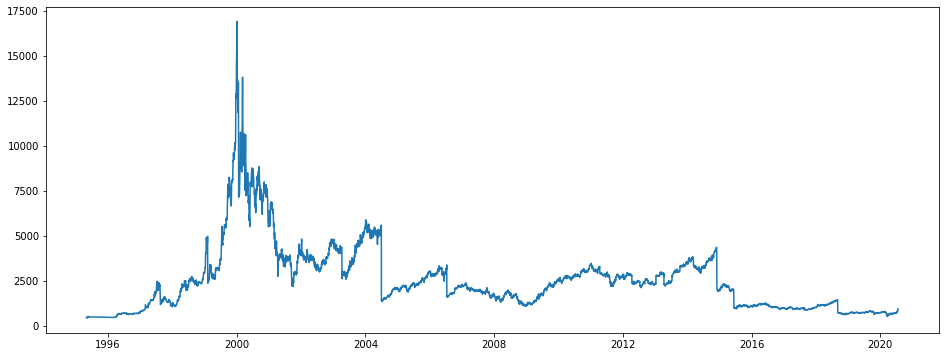

In [8]:
# Plotting the time series.
plt.figure(figsize=(16,6))
plt.plot(Stock_data['Close'])
plt.show()

<Figure size 432x288 with 0 Axes>

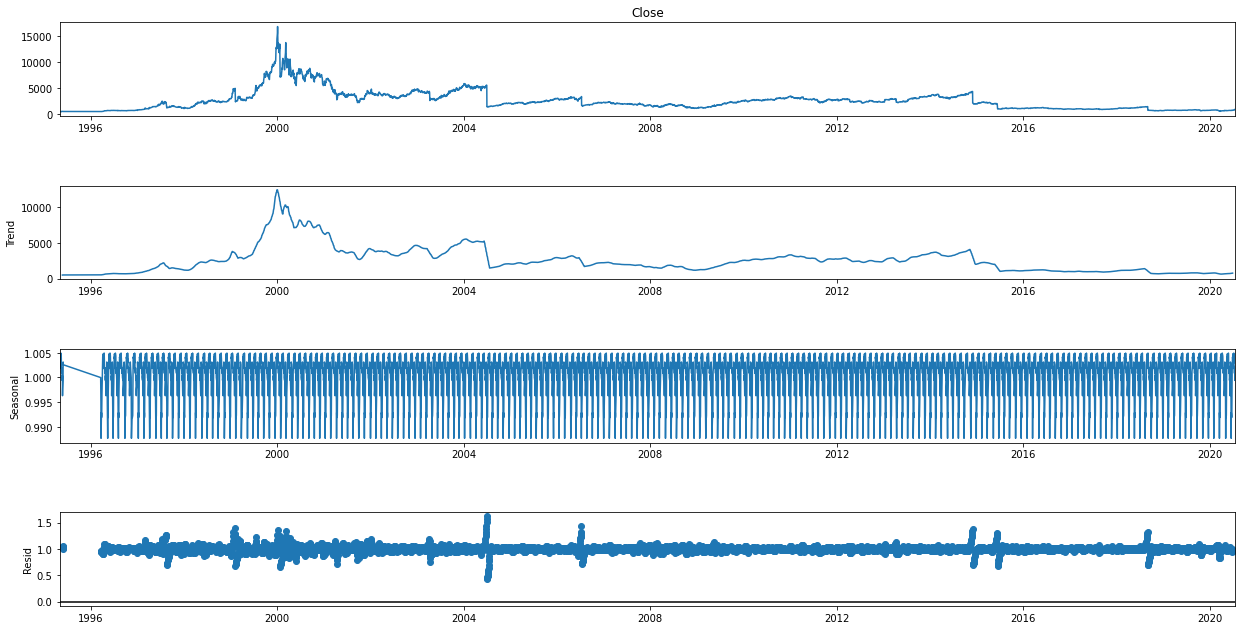

In [9]:
# Checking decomposition of trend, seasonality and residue of the original time seires.
decomposition = seasonal_decompose(Stock_data['Close'], model='multiplicative', period=30)
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(20, 10)


ADF Test:
Null Hypothesis: Not Stationary
ADF Statistic: -2.357454
p-value: 0.154107
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
KPSS Test:
Null Hypothesis: Stationary
KPSS Statistic: 4.174144
p-value: 0.010000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1661: FutureWarning:

The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1685: InterpolationWarning:

p-value is smaller than the indicated p-value



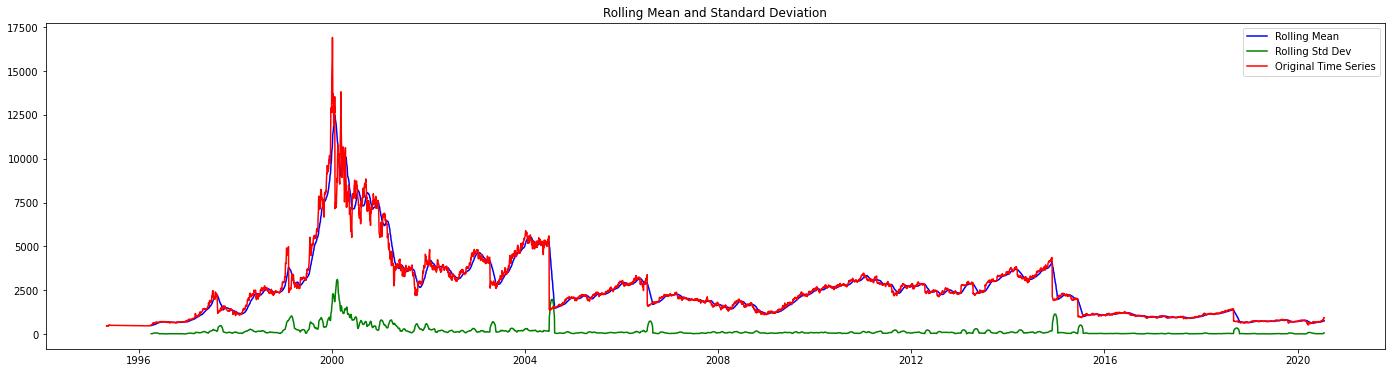

In [10]:
#Testing for stationarity using ADF and KPSS Tests.

def stationarity_test(stock_close_price):
    # Calculating rolling mean and rolling standard deviation:
    rolling_mean = stock_close_price.rolling(30).mean()
    rolling_std_dev = stock_close_price.rolling(30).std()
  
    # Plotting the statistics:
    plt.figure(figsize=(24,6))
    plt.plot(rolling_mean, color='blue', label='Rolling Mean')
    plt.plot(rolling_std_dev, color='green', label = 'Rolling Std Dev')
    plt.plot(stock_close_price, color='red',label='Original Time Series')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    
    print("ADF Test:")
    adf_test = adfuller(stock_close_price,autolag='AIC')
    print('Null Hypothesis: Not Stationary')
    print('ADF Statistic: %f' % adf_test[0])
    print('p-value: %f' % adf_test[1])
    print('Critical Values:')
    for key, value in adf_test[4].items():
        print('\t%s: %.3f' % (key, value))

    print("KPSS Test:")
    kpss_test = kpss(stock_close_price, regression='c', nlags=None, store=False)
    print('Null Hypothesis: Stationary')
    print('KPSS Statistic: %f' % kpss_test[0])
    print('p-value: %f' % kpss_test[1])
    print('Critical Values:')
    for key, value in kpss_test[3].items():
        print('\t%s: %.3f' % (key, value))
    
stationarity_test(Stock_data['Close'])

ADF Test:
Null Hypothesis: Not Stationary
ADF Statistic: -8.602555
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
KPSS Test:
Null Hypothesis: Stationary
KPSS Statistic: 0.120283
p-value: 0.100000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1661: FutureWarning:

The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1687: InterpolationWarning:

p-value is greater than the indicated p-value



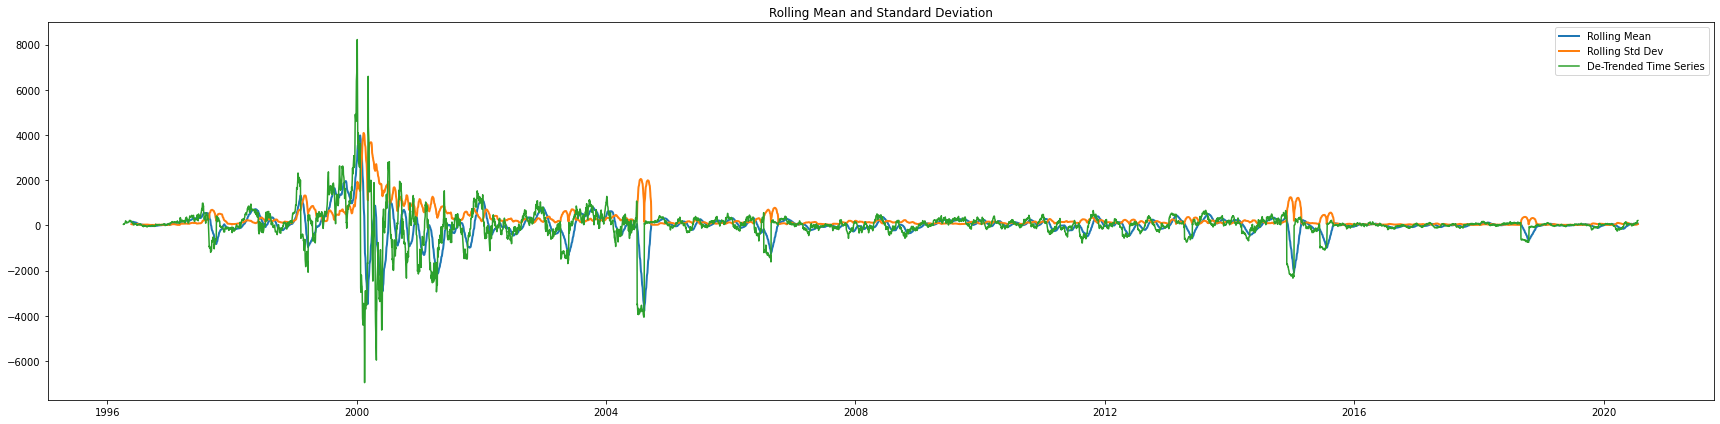

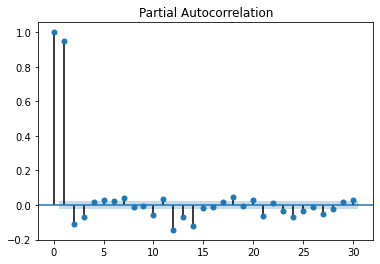

In [11]:
#Testing for stationarity of de-trended time series using ADF and KPSS Tests.

# De-trending the time series
# Stock_data['Close_Detrend'] = (Stock_data['Close'] - Stock_data['Close'].rolling(window=30).mean()) / Stock_data['Close'].rolling(window=30).std()
Stock_data['Close_Detrend'] = (Stock_data['Close'] - Stock_data['Close'].shift(30))

def stationarity_test(stock_close_price):
    # Calculating rolling mean and rolling standard deviation:
    rolling_mean = stock_close_price.rolling(30).mean()
    rolling_std_dev = stock_close_price.rolling(30).std()
  
    # Plotting the statistics:
    plt.figure(figsize=(24,6))
    plt.plot(rolling_mean, label='Rolling Mean',linewidth=2.0)
    plt.plot(rolling_std_dev, label = 'Rolling Std Dev',linewidth=2.0)
    plt.plot(stock_close_price,label='De-Trended Time Series')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.tight_layout()
    
    print("ADF Test:")
    adf_test = adfuller(stock_close_price,autolag='AIC')
    print('Null Hypothesis: Not Stationary')
    print('ADF Statistic: %f' % adf_test[0])
    print('p-value: %f' % adf_test[1])
    print('Critical Values:')
    for key, value in adf_test[4].items():
        print('\t%s: %.3f' % (key, value))

    print("KPSS Test:")
    kpss_test = kpss(stock_close_price, regression='c', nlags=None, store=False)
    print('Null Hypothesis: Stationary')
    print('KPSS Statistic: %f' % kpss_test[0])
    print('p-value: %f' % kpss_test[1])
    print('Critical Values:')
    for key, value in kpss_test[3].items():
        print('\t%s: %.3f' % (key, value))
    
stationarity_test(Stock_data['Close_Detrend'].dropna())

# PACF Plot
from statsmodels.graphics.tsaplots import plot_pacf
pacf = plot_pacf(Stock_data['Close_Detrend'].dropna(), lags=30, alpha=0.05)


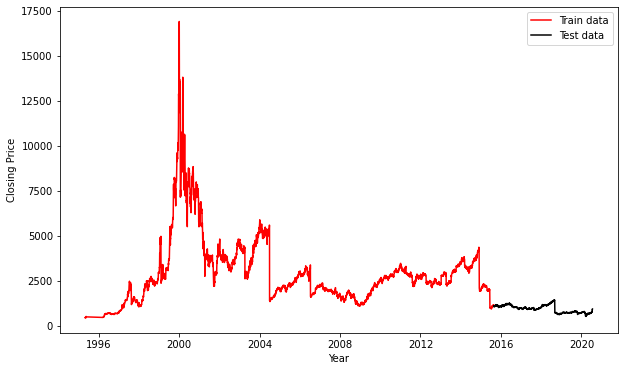

In [12]:
#split data into train and training set
Stock_data_arima = Stock_data['Close']
train_test_split_ratio = int(len(Stock_data_arima)*0.8)
train_data, test_data = Stock_data_arima[:train_test_split_ratio], Stock_data_arima[train_test_split_ratio:]


# Plotting the train and test sets.
plt.figure(figsize=(10,6))
plt.xlabel('Year')
plt.ylabel('Closing Price')
plt.plot(train_data, 'red', label='Train data')
plt.plot(test_data, 'black', label='Test data')
plt.legend()

Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=63991.913, BIC=64017.848, Time=2.256 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=63998.386, BIC=64011.353, Time=0.134 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=63994.505, BIC=64013.955, Time=0.169 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=63995.268, BIC=64014.719, Time=0.461 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=63996.389, BIC=64002.873, Time=0.086 seconds
Fit ARIMA(2,1,1)x(0,0,0,0) [intercept=True]; AIC=63998.018, BIC=64030.437, Time=1.345 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=63960.774, BIC=63993.193, Time=1.842 seconds
Fit ARIMA(0,1,2)x(0,0,0,0) [intercept=True]; AIC=63965.295, BIC=63991.229, Time=0.874 seconds
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=63960.087, BIC=63998.989, Time=2.876 seconds
Fit ARIMA(3,1,2)x(0,0,0,0) [intercept=True]; AIC=63921.929, BIC=63967.315, Time=4.726 seconds
Fit ARIMA(3,1,1)

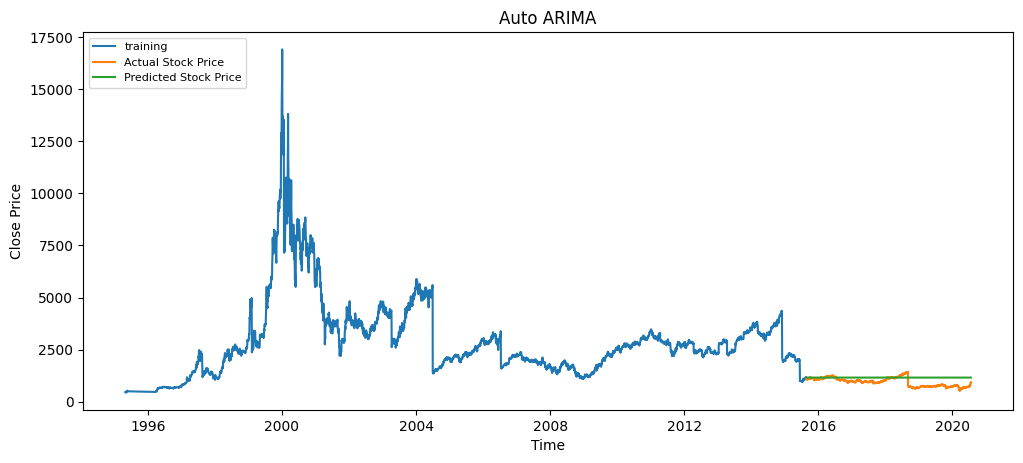

Auto-Arima RMSE :- 293.204


In [13]:
# Auto ARIMA Method
arima_model = auto_arima(train_data,
                      start_p=1, start_q=1,
                      max_p=5, max_q=5,
                      test='adf',        
                      trace=True,
                      alpha=0.05,
                      scoring='mse',
                      suppress_warnings=True,
                      seasonal = False
                      )

# Fitting the final model with the order
fitted_model = arima_model.fit(train_data) 
print(fitted_model.summary())

# Forecasting the values.
forecast_values = fitted_model.predict(len(test_data), alpha=0.05) 
fcv_series = pd.Series(forecast_values[0], index=test_data.index)

#Plotting the predicted stock price and original price.
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, label='Actual Stock Price')
plt.plot(fcv_series,label='Predicted Stock Price')
plt.title('Auto ARIMA')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

# Evaluating the model by calculating RMSE.
rms_auto_arima = sqrt(mean_squared_error(test_data.values, fcv_series))
print("Auto-Arima RMSE :- " + str(round(rms_auto_arima,3)))

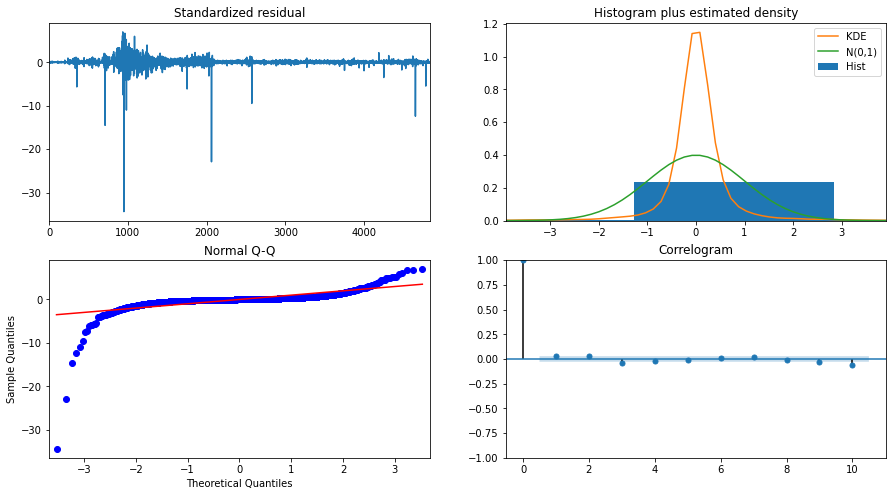

In [14]:
# Plotting the diagnostics of the fiited model.
arima_model.plot_diagnostics(figsize=(15,8))
plt.show()

Simple Exponential Smoothing Method

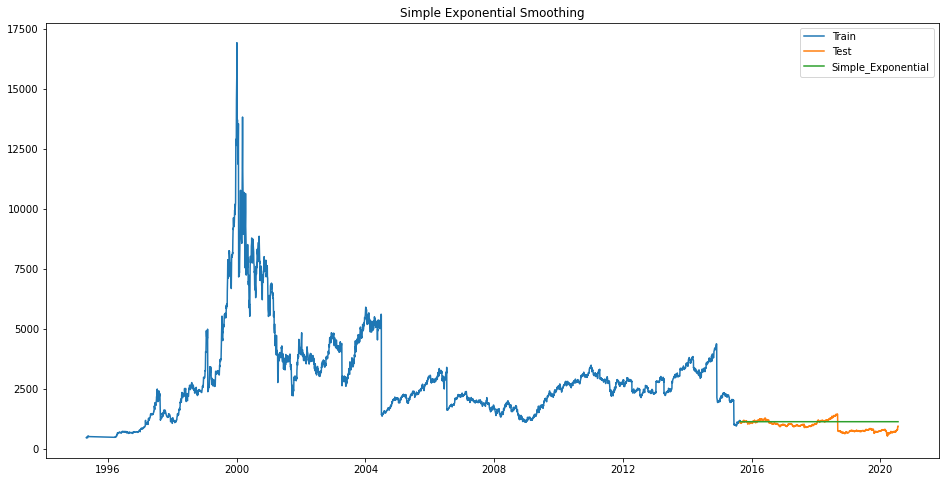

Simple Exponential Smoothing RMS :- 266.584 & Smoothing Level :- 0.1


In [15]:
# Simple Exponential Smoothing Method
pred_values = test_data.copy()
pred_values = pd.DataFrame(pred_values)

Simple_Exponential_df = pd.DataFrame(columns = ['RMS','Smoothing Level'])

from itertools import permutations
perm = permutations(list(np.linspace(0.05,1,num=20)), 1)
for i in list(perm):
  fit_sim_exp = SimpleExpSmoothing(np.asarray(train_data)).fit(smoothing_level = i[0])
  pred_values['Simple_Exponential'] = fit_sim_exp.forecast(len(test_data))

  rms = round(sqrt(mean_squared_error(test_data.values, pred_values.Simple_Exponential)),3)
  Simple_Exponential_df = Simple_Exponential_df.append(other = {'RMS' : rms , 'Smoothing Level' : i[0]} , ignore_index=True)

opt_values = Simple_Exponential_df.loc[Simple_Exponential_df['RMS'] == min(Simple_Exponential_df['RMS']),['Smoothing Level']].values


# Using optimised values from the lists.
fit_sim_exp = SimpleExpSmoothing(np.asarray(train_data)).fit(smoothing_level = opt_values[0][0])
pred_values['Simple_Exponential'] = fit_sim_exp.forecast(len(test_data))

plt.figure(figsize=(16,8))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(pred_values['Simple_Exponential'], label='Simple_Exponential')
plt.legend(loc='best')
plt.title('Simple Exponential Smoothing')
plt.show()

rms_sim_exp = sqrt(mean_squared_error(test_data.values, pred_values.Simple_Exponential))
print("Simple Exponential Smoothing RMS :- " + str(round(rms_sim_exp,3)) + " & Smoothing Level :- "+str(round(opt_values[0][0],3)))



Holt's Exponential Smoothing Model


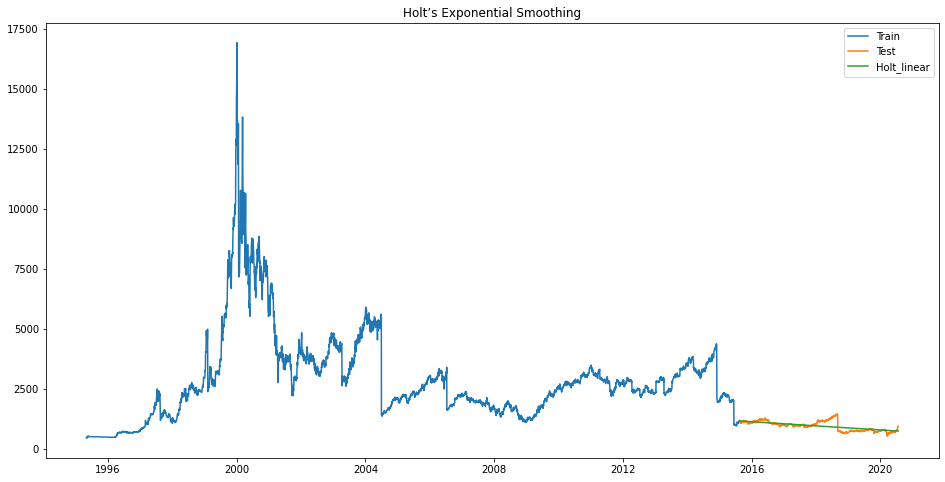

Holt’s Exponential Smoothing RMS :- 146.028 & Smoothing Level :- 0.75 & Smoothing Slope :- 0.05


In [16]:
# Holt's Exponential Smoothing Method
holt_linear_df = pd.DataFrame(columns = ['RMS','Smoothing Level','Smoothing Slope'])

from itertools import permutations
perm = permutations(list(np.linspace(0.05,1,num=20)), 2)
for i in list(perm):
  fit_holt = Holt(np.asarray(train_data)).fit(smoothing_level = i[0],smoothing_slope=i[1])
  pred_values['Holt_linear'] = fit_holt.forecast(len(test_data))

  rms = round(sqrt(mean_squared_error(test_data.values, pred_values.Holt_linear)),3)
  holt_linear_df = holt_linear_df.append(other = {'RMS' : rms , 'Smoothing Level' : i[0], 'Smoothing Slope':i[1]} , ignore_index=True)

opt_values = holt_linear_df.loc[holt_linear_df['RMS'] == min(holt_linear_df['RMS']),['Smoothing Level','Smoothing Slope']].values


# Using optimised values from the lists.
fit_holt = Holt(np.asarray(train_data)).fit(smoothing_level = opt_values[0][0],smoothing_slope=opt_values[0][1])
pred_values['Holt_linear'] = fit_holt.forecast(len(test_data))

plt.figure(figsize=(16,8))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(pred_values['Holt_linear'], label='Holt_linear')
plt.legend(loc='best')
plt.title('Holt’s Exponential Smoothing')
plt.show()

rms_holt_exp = sqrt(mean_squared_error(test_data.values, pred_values.Holt_linear))
print("Holt’s Exponential Smoothing RMS :- " + str(round(rms_holt_exp,3)) + " & Smoothing Level :- "+str(round(opt_values[0][0],3)) + " & Smoothing Slope :- "+str(round(opt_values[0][1],3)))



In [17]:
# Printing RMSE of all the methods
print("RMSE of all the methods")
print("Auto-Arima:- " + str(round(rms_auto_arima,3)))
print("Simple Exponential Smoothing:- " + str(round(rms_sim_exp,3)))
print("Holt’s Exponential Smoothing:- " + str(round(rms_holt_exp,3)))


RMSE of all the methods
Auto-Arima:- 293.204
Simple Exponential Smoothing:- 266.584
Holt’s Exponential Smoothing:- 146.028
